In [3]:
# install the required libraries for the script to run.
!pip install docplex
!pip install cplex
!pip install networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.6/635.6 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for docplex: filename=docplex-2.27.239-py3-none-any.whl size=674503 sha256=3f1582021f2586781906f8d5444e36027cc1e5e0be7c6de9ef8dd1d067787832
  Stored in directory: /root/.cache/pip/wheels/62/7c/db/cef9425e1cedbf45621545097eaaeed5efe07005bd8229dd74
Successfully built docplex
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 MB 11.4 MB/s eta 0:00:00


In [4]:
# import required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import networkx as nx

# model
import cplex
from docplex.mp.model import Model
import time


print(cplex.__version__)

22.1.1.0


# Data
We have two datasets: RG30 and RG300.

- **RG30** consists of instances with 30 activities. For our analysis, we are specifically working with RG30 set 1, focusing on 20 instances numbered from 301 to 320. These datasets are commonly used for benchmarking algorithms and evaluating the performance of scheduling techniques on smaller-scale problems.

- **RG300** comprises instances with 300 activities, offering more challenging scenarios. Although we are primarily focusing on RG30, we also examine one instance from the RG300 dataset. This allows us to explore more complex instances and test the scalability and efficiency of scheduling algorithms on larger-scale problems.

![dataset_table](https://github.com/ezzaddeentru/RCPS_301_320/raw/main/dataset_info_8-6-2024_14583_www.projectmanagement.ugent.be.jpeg)

[Image source](https://www.projectmanagement.ugent.be/research/data/RanGen)



In [5]:
# get a RG30 and RG300 folder data from github
!git clone https://github.com/ezzaddeentru/RCPS_301_320.git


Cloning into 'RCPS_301_320'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 37 (delta 5), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (37/37), 124.90 KiB | 2.90 MiB/s, done.
Resolving deltas: 100% (5/5), done.


## RG30
Let's look at the instances with 30 activities and extract the data for ES and LS calculations and our model.

In [ ]:
# Get the list of RG30 data files and print them
filenames = sorted(os.listdir("/content/RCPS_301_320/RG30_301_320"))
for filename in filenames:
    print(filename)

Pat301.rcp
Pat302.rcp
Pat303.rcp
Pat304.rcp
Pat305.rcp
Pat306.rcp
Pat307.rcp
Pat308.rcp
Pat309.rcp
Pat310.rcp
Pat311.rcp
Pat312.rcp
Pat313.rcp
Pat314.rcp
Pat315.rcp
Pat316.rcp
Pat317.rcp
Pat318.rcp
Pat319.rcp
Pat320.rcp


In [ ]:
# read all RG30 data files
for filename in filenames:
    with open(os.path.join("/content/RCPS_301_320/RG30_301_320", filename), 'r') as f:
        contents = f.read()
        print(filename)
        print(contents)

Pat301.rcp

  32    4
  10   10   10   10

   0   0   0   0   0   2 2 8 
   1   1   1   0   1   4 20 14 13 3 
   9   5   5   0   4   4 31 30 18 4 
   7   7   3   0   4   2 11 5 
   3   4   0   1   2   5 29 28 24 19 6 
   8   0   2   4   4   2 17 7 
   7   4   0   1   4   2 27 9 
   4   6   6   0   8   3 31 18 11 
  10   7   3   3   0   3 26 25 10 
   2   1   2   0   5   2 23 12 
   5   2   5   0   3   2 23 12 
   4   5   0   4   1   2 22 15 
   1   0   4   6   4   2 21 18 
   8   0   2   4   5   1 15 
   4   3   4   0   4   1 16 
   1   2   0   3   6   1 21 
   3   8   4   0   5   1 21 
   7   2   7   0   3   1 24 
   4   4   0   4   2   1 21 
  10   0   4   6   5   1 30 
   8   1   2   5   0   1 32
   6   4   0   8   4   1 32
  10   3   3   0   6   1 32
   2   0   3   5   4   1 32
   4   0   9   1   5   1 32
   2   5   3   3   0   1 32
   1   4   7   7   0   1 32
  10   7   0   2   3   1 32
   5   0   3   4   4   1 32
   2   3   5   3   0   1 32
   9   0   5   6   4   1 32
   0   0   

In [6]:
# read RG30 data
def read_instance(filename):
    """
    Reads a resource-constrained project scheduling problem (RCPSP) instance from a file.

    This function parses the RCPSP data from a specified file, extracting the number of activities,
    the number of resources, the capacity of each resource, activity durations, the number of successors
    for each activity, successor relationships, and resource requirements for each activity.

    Args:
        filename (str): The path to the file containing the RCPSP instance data.

    Returns:
        tuple: A tuple containing the following elements:
            - nb_activities (int): The number of activities in the project.
            - nb_resources (int): The number of resources available.
            - capacity (list of int): The capacity of each resource.
            - duration (list of int): The duration of each activity.
            - nb_successors (list of int): The number of successors for each activity.
            - successors (list of list of int): The list of successor activities for each activity.
            - horizon (int): The total time required to complete all activities.
            - resources (list of list of int): The resource requirements for each activity.

    References:
        Hexaly Documentation: https://www.hexaly.com/docs/last/exampletour/resource-constrained-project-scheduling-problem-rcpsp.html
    """
    # Read the file and extract the data
    with open(filename) as f:
        lines = f.readlines()

    first_line = lines[1].split()
    nb_activities = int(first_line[0])
    nb_resources = int(first_line[1])
    capacity = [int(lines[2].split()[r]) for r in range(nb_resources)]

    duration = [0 for i in range(nb_activities)]
    nb_successors = [0 for i in range(nb_activities)]
    successors = [[] for i in range(nb_activities)]
    resources = [[0 for r in range(nb_resources)] for i in range(nb_activities)]

    for i in range(nb_activities):
        line = lines[i + 4].split()
        duration[i] = int(line[0])
        for r in range(nb_resources):
            resources[i][r] = int(line[1 + r])
        nb_successors[i] = int(line[nb_resources + 1])
        # successors are reindexed to be 0-indexed
        successors[i] = [int(line[nb_resources + 2 + s]) - 1 for s in range(nb_successors[i])]

    horizon = sum(duration[i] for i in range(nb_activities))

    return nb_activities, nb_resources, capacity, duration, nb_successors, successors, horizon, resources

In [16]:
# data file path
pat301 = "/content/RCPS_301_320/RG30_301_320/Pat301.rcp"

In [ ]:
# read data file
with open(pat301, 'r') as f:
    contents = f.read()
print(contents)


  32    4
  10   10   10   10

   0   0   0   0   0   2 2 8 
   1   1   1   0   1   4 20 14 13 3 
   9   5   5   0   4   4 31 30 18 4 
   7   7   3   0   4   2 11 5 
   3   4   0   1   2   5 29 28 24 19 6 
   8   0   2   4   4   2 17 7 
   7   4   0   1   4   2 27 9 
   4   6   6   0   8   3 31 18 11 
  10   7   3   3   0   3 26 25 10 
   2   1   2   0   5   2 23 12 
   5   2   5   0   3   2 23 12 
   4   5   0   4   1   2 22 15 
   1   0   4   6   4   2 21 18 
   8   0   2   4   5   1 15 
   4   3   4   0   4   1 16 
   1   2   0   3   6   1 21 
   3   8   4   0   5   1 21 
   7   2   7   0   3   1 24 
   4   4   0   4   2   1 21 
  10   0   4   6   5   1 30 
   8   1   2   5   0   1 32
   6   4   0   8   4   1 32
  10   3   3   0   6   1 32
   2   0   3   5   4   1 32
   4   0   9   1   5   1 32
   2   5   3   3   0   1 32
   1   4   7   7   0   1 32
  10   7   0   2   3   1 32
   5   0   3   4   4   1 32
   2   3   5   3   0   1 32
   9   0   5   6   4   1 32
   0   0   0   0   0  

In [17]:
# extract data file information
nb_activities, nb_resources, capacity, duration, nb_successors, successors, horizon, resources = read_instance(pat301)
print(f" nb_activities: {nb_activities}\n nb_resources: {nb_resources}\n resources: {resources}\n capacity: {capacity}\n duration: {duration}\n nb_successors: {nb_successors}\n successors: {successors}\n Total duration: {horizon}")


 nb_activities: 32
 nb_resources: 4
 resources: [[0, 0, 0, 0], [1, 1, 0, 1], [5, 5, 0, 4], [7, 3, 0, 4], [4, 0, 1, 2], [0, 2, 4, 4], [4, 0, 1, 4], [6, 6, 0, 8], [7, 3, 3, 0], [1, 2, 0, 5], [2, 5, 0, 3], [5, 0, 4, 1], [0, 4, 6, 4], [0, 2, 4, 5], [3, 4, 0, 4], [2, 0, 3, 6], [8, 4, 0, 5], [2, 7, 0, 3], [4, 0, 4, 2], [0, 4, 6, 5], [1, 2, 5, 0], [4, 0, 8, 4], [3, 3, 0, 6], [0, 3, 5, 4], [0, 9, 1, 5], [5, 3, 3, 0], [4, 7, 7, 0], [7, 0, 2, 3], [0, 3, 4, 4], [3, 5, 3, 0], [0, 5, 6, 4], [0, 0, 0, 0]]
 capacity: [10, 10, 10, 10]
 duration: [0, 1, 9, 7, 3, 8, 7, 4, 10, 2, 5, 4, 1, 8, 4, 1, 3, 7, 4, 10, 8, 6, 10, 2, 4, 2, 1, 10, 5, 2, 9, 0]
 nb_successors: [2, 4, 4, 2, 5, 2, 2, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 successors: [[1, 7], [19, 13, 12, 2], [30, 29, 17, 3], [10, 4], [28, 27, 23, 18, 5], [16, 6], [26, 8], [30, 17, 10], [25, 24, 9], [22, 11], [22, 11], [21, 14], [20, 17], [14], [15], [20], [20], [23], [20], [29], [31], [31], [31], [31], [31], [31], [

In [ ]:
len(duration), len(nb_successors), len(successors), len(resources), len(successors)

(32, 32, 32, 32, 32)

## RG300
Let's look at one instance with 300 activities and extract the data for ES and LS calculations and our model.

In [8]:
# read RG300 data
def read_instance_300(filename):
    """
    Reads a resource-constrained project scheduling problem (RCPSP) instance from a file.

    This function parses the RCPSP data from a specified file, extracting the number of activities,
    the number of resources, the capacity of each resource, activity durations, the number of successors
    for each activity, successor relationships, and resource requirements for each activity.

    Args:
        filename (str): The path to the file containing the RCPSP instance data.

    Returns:
        tuple: A tuple containing the following elements:
            - nb_activities (int): The number of activities in the project.
            - nb_resources (int): The number of resources available.
            - capacity (list of int): The capacity of each resource.
            - duration (list of int): The duration of each activity.
            - nb_successors (list of int): The number of successors for each activity.
            - successors (list of list of int): The list of successor activities for each activity.
            - resources (list of list of int): The resource requirements for each activity.

    Author:
        Ezzaddeen Mofarreh
    """
    # Read the file and extract the data
    with open(filename) as f:
        content = f.readlines()

    # Step 1: Read the header line
    header = content[0].strip().split()
    num_activities = int(header[0])
    num_resources = int(header[1])

    # Step 2: Read the resource availability
    capacity = list(map(int, content[1].strip().split()))

    # Step 3: Read activity details
    resources = []
    durations = []
    num_successors_list = []
    successors_list = []
    current_line = 2

    while current_line < len(content):
        parts = content[current_line].strip().split()
        if len(parts) < num_resources + 2:
            current_line += 1
            continue  # Skip improperly formatted lines

        duration = int(parts[0])
        resource_requirements = list(map(int, parts[1:num_resources + 1]))
        num_successors = int(parts[num_resources + 1])

        # Read successors from the current line and subsequent lines
        successors = parts[num_resources + 2:]
        current_line += 1

        while len(successors) < num_successors:
            if current_line < len(content):
                successors.extend(content[current_line].strip().split())
                current_line += 1
            else:
                break  # Exit the loop if current_line is out of range

        # Convert successors to integers and adjust indices to be 0-indexed
        successors = [int(s) - 1 for s in successors]

        # Store activity details
        resources.append(resource_requirements)
        durations.append(duration)
        num_successors_list.append(num_successors)
        successors_list.append(successors)


    # Calculate the horizon
    horizon = sum(durations[i] for i in range(num_activities))

    return num_activities, num_resources, capacity, durations, num_successors_list, successors_list, horizon, resources


In [9]:
# data file path
RG300_1 = "/content/RCPS_301_320/RG300_1_5/RG300_1.rcp"


In [15]:
num_activities, num_resources, capacity_list, duration_list, num_successors_list, successors_list, horizon, resources_list = read_instance_300(RG300_1)
print(f" num_activities: {num_activities}\n num_resources: {num_resources}\n capacity_list: {capacity_list}\n resources_list: {resources_list}\n duration_list: {duration_list}\n num_successors_list: {num_successors_list}\n successors_list: {successors_list}\n Total duration: {horizon}")


 num_activities: 302
 num_resources: 4
 capacity_list: [10, 10, 10, 10]
 resources_list: [[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 3, 0, 0], [0, 0, 0, 1], [0, 2, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 2, 0], [0, 1, 0, 0], [0, 0, 0, 3], [0, 0, 4, 0], [1, 0, 0, 0], [0, 2, 0, 0], [0, 3, 0, 0], [0, 0, 3, 0], [0, 0, 0, 1], [0, 0, 2, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 4, 0], [4, 0, 0, 0], [0, 0, 3, 0], [0, 0, 0, 2], [0, 0, 3, 0], [0, 0, 3, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1], [3, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 3, 0], [0, 3, 0, 0], [0, 4, 0, 0], [0, 0, 0, 1], [0, 0, 2, 0], [0, 0, 0, 2], [0, 1, 0, 0], [0, 4, 0, 0], [1, 0, 0, 0], [0, 0, 0, 3], [0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 3], [1, 0, 0, 0], [0, 0, 0, 2], [0, 0, 3, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 2, 0, 0], [0, 0, 0, 2], [0, 0, 0, 2], [2, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 2, 0], 

In [ ]:
len(duration_list), len(num_successors_list), len(successors_list), len(resources_list), len(successors_list)

(302, 302, 302, 302, 302)

In [ ]:
# read data file
with open(RG300_1, 'r') as f:
    contents = f.read()
print(contents)

302     4       
10      10      10      10      
0       0       0       0       0       72      2       3       4       5       6       7       8       9       10      11      12      13      14      15      16      17      18      19      20      21      
 22      23      24      25      26      27      28      29      30      31      32      33      34      35      36      38      40      41      42      44      
 45      46      48      49      50      52      53      54      55      57      58      59      61      62      65      66      67      70      72      74      
 75      76      78      91      92      94      95      98      106     109     118     131     
3       0       1       0       0       33      60      80      89      96      105     114     126     129     139     142     146     147     152     154     156     157     160     162     164     170     
 172     175     177     179     181     202     205     213     286     288     290     292     293     
8   

In [ ]:
# understand the format of the RG300 dataset
for i in range(len(contents)):
  print(i, '--', len(contents[i].split()), '--', contents[i])

0 -- 2 -- 302     4       

1 -- 4 -- 10      10      10      10      

2 -- 26 -- 0       0       0       0       0       72      2       3       4       5       6       7       8       9       10      11      12      13      14      15      16      17      18      19      20      21      

3 -- 20 --  22      23      24      25      26      27      28      29      30      31      32      33      34      35      36      38      40      41      42      44      

4 -- 20 --  45      46      48      49      50      52      53      54      55      57      58      59      61      62      65      66      67      70      72      74      

5 -- 12 --  75      76      78      91      92      94      95      98      106     109     118     131     

6 -- 26 -- 3       0       1       0       0       33      60      80      89      96      105     114     126     129     139     142     146     147     152     154     156     157     160     162     164     170     

7 -- 13 --  172     175     

# Network Digraph
Let's graph the network for one instance of the RG30

In [ ]:
def draw_task_network(nb_activities, duration, resources, successors):
    """
    Draw an AoN network graph.

    Args:
    - nb_activities (int): Number of activities.
    - duration (list): List of activity durations.
    - resources (list): List of resource requirements for each activity.
    - successors (list): List of activity successors.
    """
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes with durations and resource requirements
    for i in range(nb_activities):
        G.add_node(i, duration=duration[i], resources=resources[i])

    # Add edges representing dependencies
    for i in range(nb_activities):
        for succ in successors[i]:
            G.add_edge(i, succ)

    # Plot the graph
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=7, font_weight='bold')
    edge_labels = {(i, j): f"" for i, j in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title('AoN Network')
    plt.show()

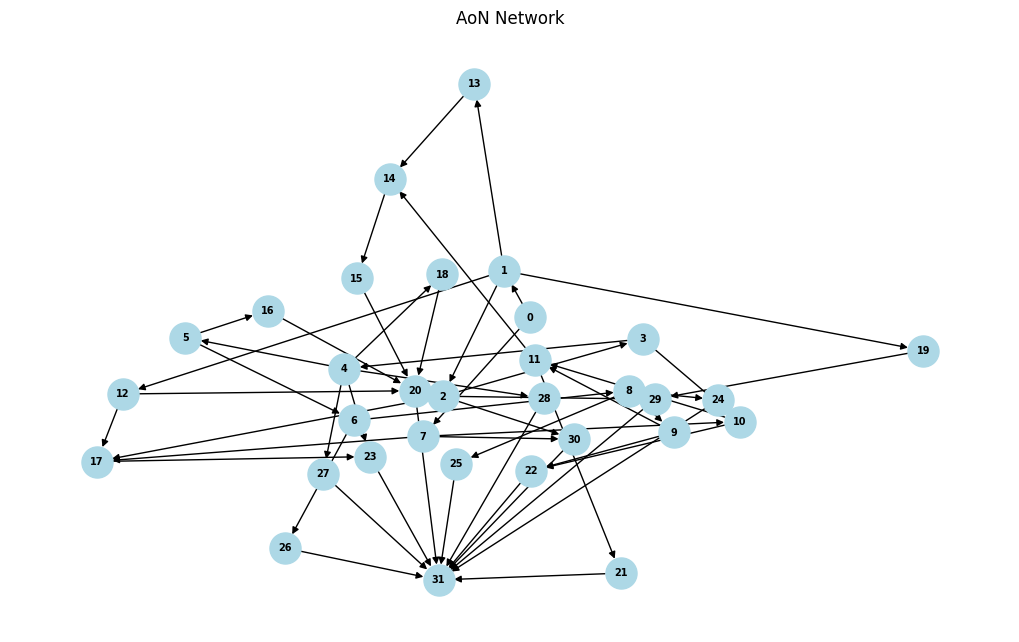

In [ ]:
draw_task_network(nb_activities, duration, resources, successors)

Let's try to graph the network for the RG300 dataset, even though it might not look perfect.

In [ ]:
def draw_task_network_300(nb_activities, duration, resources, successors):
    """
    Draw an AoN network graph.

    Args:
    - nb_activities (int): Number of activities.
    - duration (list): List of activity durations.
    - resources (list): List of resource requirements for each activity.
    - successors (list): List of activity successors.
    """
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes with durations and resource requirements
    for i in range(nb_activities):
        G.add_node(i, duration=duration[i], resources=resources[i])

    # Add edges representing dependencies
    for i in range(nb_activities):
        for succ in successors[i]:
            G.add_edge(i, succ)

    # Plot the graph
    plt.figure(figsize=(20, 15))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=7, font_weight='bold')
    edge_labels = {(i, j): f"" for i, j in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title('AoN Network')
    plt.show()

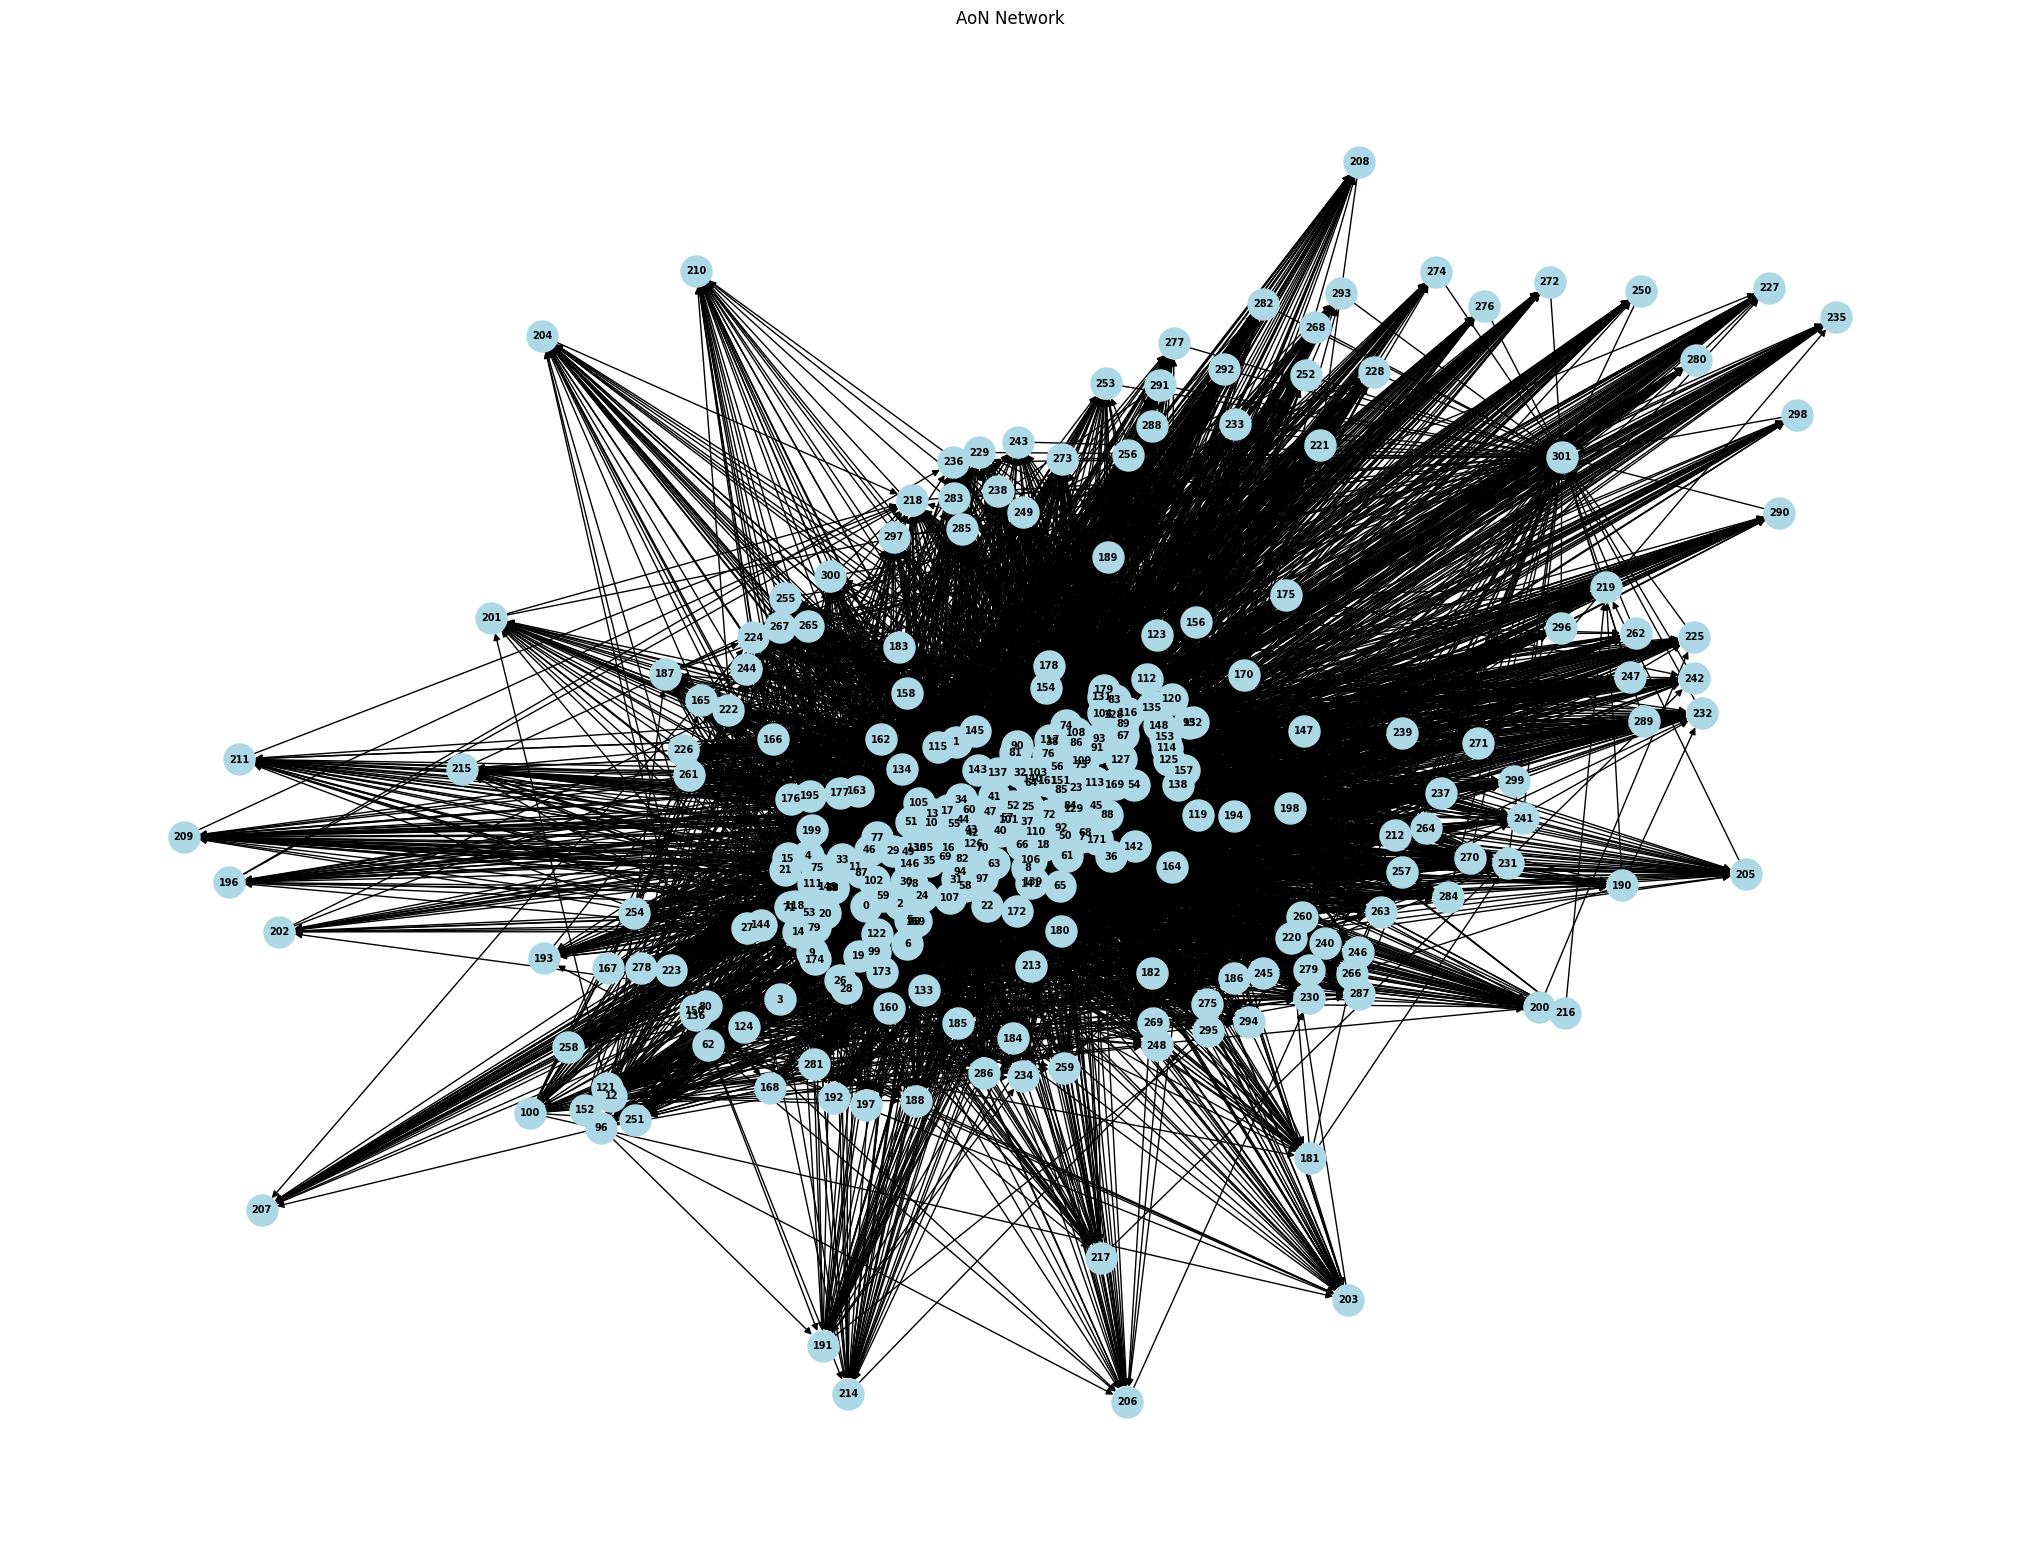

In [ ]:
draw_task_network_300(num_activities, duration_list, resources_list, successors_list)

# CPM Algorithm - ES and LS times Calculation

In [11]:
# CPM Algorithm
def forward_pass(nb_activities, duration, successors):
    """
    Performs the forward pass in the Critical Path Method (CPM) to calculate
    the earliest start (ES) and earliest finish (EF) times for each task.

    Parameters:
    nb_activities (int): The number of activities in the project.
    duration (list): A list of activity durations.
    successors (list): A list of lists containing successors for each activity.

    Returns:
    tuple: A tuple containing:
        - ES (list): Earliest start times for each activity.
        - EF (list): Earliest finish times for each activity.
    """
    ES = [0] * nb_activities
    EF = [0] * nb_activities

    for i in range(nb_activities):
        EF[i] = ES[i] + duration[i]
        for succ in successors[i]:
            ES[succ] = max(ES[succ], EF[i])
            EF[succ] = ES[succ] + duration[succ]

    return ES, EF

def backward_pass(nb_activities, duration, successors, EF):
    """
    Performs the backward pass in the Critical Path Method (CPM) to calculate
    the latest start (LS) and latest finish (LF) times for each activity.

    Parameters:
    nb_activities (int): The number of activities in the project.
    duration (list): A list of activity durations.
    successors (list): A list of lists containing successors for each activity.
    EF (list): Earliest finish times for each activity.

    Returns:
    tuple: A tuple containing:
        - LS (list): Latest start times for each activity.
        - LF (list): Latest finish times for each activity.
    """
    horizon = max(EF)
    LS = [horizon] * nb_activities
    LF = [horizon] * nb_activities

    for i in reversed(range(nb_activities)):
        if not successors[i]:
            LS[i] = horizon - duration[i]
            LF[i] = horizon
        else:
            for succ in successors[i]:
                LS[i] = min(LS[i], LS[succ] - duration[i])
                LF[i] = LS[i] + duration[i]

    return LS, LF

In [12]:
# calculate and print functions
def calculate_early_and_late_start_times(filename, read_instance_fn):
    """
    Calculates the earliest and latest start and finish times for activities
    in a project scheduling problem using the Critical Path Method (CPM).

    Parameters:
    filename (str): The name of the file containing the instance data.

    Returns:
    tuple: A tuple containing:
        - ES (list): Earliest start times for each activity.
        - EF (list): Earliest finish times for each activity.
        - LS (list): Latest start times for each activity.
        - LF (list): Latest finish times for each activity.
    """
    nb_activities, nb_resources, capacity, duration, nb_successors, successors, horizon, resources = read_instance_fn(filename)
    ES, EF = forward_pass(nb_activities, duration, successors)
    LS, LF = backward_pass(nb_activities, duration, successors, EF)
    return ES, EF, LS, LF

def print_activity_times(ES, EF, LS, LF, duration):
    """
    Prints the early start (ES), early finish (EF), late start (LS), and late finish (LF) times
    for each activity along with their durations.

    Parameters:
    ES (list): Earliest start times for each activity.
    EF (list): Earliest finish times for each activity.
    LS (list): Latest start times for each activity.
    LF (list): Latest finish times for each activity.
    duration (list): Durations of each activity.

    Returns:
    None
    """
    print("Activity\tDuration\tES\tEF\tLS\tLF")
    for i in range(len(duration)):
        print(f"{i}\t\t{duration[i]}\t\t{ES[i]}\t{EF[i]}\t{LS[i]}\t{LF[i]}")

def print_activity_times_df(ES, EF, LS, LF, duration):
    """
    Creates a DataFrame containing the early start (ES), early finish (EF),
    late start (LS), and late finish (LF) times for each activity along with their durations.

    Parameters:
    ES (list): Earliest start times for each activity.
    EF (list): Earliest finish times for each activity.
    LS (list): Latest start times for each activity.
    LF (list): Latest finish times for each activity.
    duration (list): Durations of each activity.

    Returns:
    pd.DataFrame: A DataFrame with columns for Activity, Duration, ES, EF, LS, and LF times.
    """
    df = pd.DataFrame({
        "Activity": range(1, len(ES) + 1),
        "Duration": duration,
        "ES": ES,
        "EF": EF,
        "LS": LS,
        "LF": LF
    })
    return df

In [ ]:
def activity_data_to_dataframe(ES, EF, LS, LF, duration, resources):
    """
    Creates a DataFrame with the early start (ES), early finish (EF), late start (LS),
    late finish (LF) times for each activity along with their durations and resource requirements.

    Parameters:
    ES (list): Earliest start times for each activity.
    EF (list): Earliest finish times for each activity.
    LS (list): Latest start times for each activity.
    LF (list): Latest finish times for each activity.
    duration (list): Durations of each activity.
    resources (list): Resource requirements for each activity.

    Returns:
    pd.DataFrame: A DataFrame containing the activity data.
    """
    # Number of activities
    num_activities = len(duration)

    # Create a dictionary to hold the data
    data = {
        'Activity': list(range(num_activities)),
        'Duration': duration,
        'ES': ES,
        'EF': EF,
        'LS': LS,
        'LF': LF
    }

    # Add resource columns to the data dictionary
    for i in range(len(resources[0])):
        data[f'R_{i + 1}'] = [resources[j][i] for j in range(num_activities)]

    # Create a DataFrame
    df = pd.DataFrame(data)

    return df

### ES & LS for RG30 instance

In [18]:
# Calculate ES, EF, LS, LF of RG30 instance
ES, EF, LS, LF = calculate_early_and_late_start_times(pat301, read_instance)
print_activity_times(ES, EF, LS, LF, duration)

Activity	Duration	ES	EF	LS	LF
0		0		0	0	0	0
1		1		0	1	0	1
2		9		1	10	1	10
3		7		10	17	10	17
4		3		17	20	17	20
5		8		20	28	20	28
6		7		28	35	28	35
7		4		0	4	38	42
8		10		35	45	35	45
9		2		45	47	45	47
10		5		17	22	42	47
11		4		47	51	47	51
12		1		1	2	54	55
13		8		1	9	43	51
14		4		51	55	51	55
15		1		55	56	55	56
16		3		28	31	53	56
17		7		10	17	55	62
18		4		20	24	52	56
19		10		1	11	52	62
20		8		56	64	56	64
21		6		51	57	58	64
22		10		47	57	54	64
23		2		20	22	62	64
24		4		45	49	60	64
25		2		45	47	62	64
26		1		35	36	63	64
27		10		20	30	54	64
28		5		20	25	59	64
29		2		11	13	62	64
30		9		10	19	55	64
31		0		64	64	64	64


In [ ]:
df = activity_data_to_dataframe(ES, EF, LS, LF, duration, resources)
# print(df)

 ### ES & LS for RG300 instance

In [19]:
# Calculate ES, EF, LS, LF of RG300 instance
ES, EF, LS, LF = calculate_early_and_late_start_times(RG300_1, read_instance_300)
print_activity_times(ES, EF, LS, LF, duration_list)

Activity	Duration	ES	EF	LS	LF
0		0		0	0	0	0
1		3		0	3	13	16
2		8		0	8	7	15
3		10		0	10	0	10
4		6		0	6	4	10
5		9		0	9	1	10
6		6		0	6	11	17
7		5		0	5	11	16
8		2		0	2	13	15
9		4		0	4	16	20
10		7		0	7	9	16
11		8		0	8	3	11
12		10		0	10	7	17
13		7		0	7	5	12
14		3		0	3	17	20
15		6		0	6	8	14
16		7		0	7	1	8
17		7		0	7	9	16
18		5		0	5	13	18
19		6		0	6	9	15
20		2		0	2	19	21
21		8		0	8	11	19
22		2		0	2	6	8
23		6		0	6	16	22
24		6		0	6	17	23
25		4		0	4	21	25
26		6		0	6	9	15
27		7		0	7	13	20
28		4		0	4	15	19
29		4		0	4	17	21
30		7		0	7	15	22
31		10		0	10	12	22
32		5		0	5	11	16
33		7		0	7	14	21
34		8		0	8	15	23
35		9		0	9	7	16
36		8		8	16	11	19
37		9		0	9	7	16
38		5		10	15	10	15
39		2		0	2	19	21
40		7		0	7	9	16
41		9		0	9	14	23
42		10		9	19	10	20
43		5		0	5	20	25
44		4		0	4	19	23
45		1		0	1	24	25
46		10		7	17	8	18
47		2		0	2	17	19
48		6		0	6	16	22
49		6		0	6	15	21
50		7		6	13	14	21
51		8		0	8	15	23
52		7		0	7	18	25
53		1		0	1	25	26
54		5		0	5	17	22
55		5		10	15	17	22
56		6		0	6	20	26
57		5		0	5	19	24


## Verification of ES and LS calculations

In [ ]:
# book's example - "Project Management with Dynamic Scheduling."
nb_activities = 14
duration = [0,6,5,3,1,3,2,1,4,3,1,3,5,0]
successors = [[2,3,4], [9], [5,6,7], [8], [10], [12], [11], [13], [14], [12], [12], [13], [14], []]

# mataching the index with the 0-index the algorithm work with
successors_0_index = [[1,2,3], [8], [4,5,6], [7], [9], [11], [10], [12], [13], [11], [11], [12], [13], []]

In [ ]:
ES, EF = forward_pass(nb_activities, duration, successors_0_index)
LS, LF = backward_pass(nb_activities, duration, successors_0_index, EF)
print_activity_times(ES, EF, LS, LF, duration)

Activity	Duration	ES	EF	LS	LF
0		0		0	0	0	0
1		6		0	6	7	13
2		5		0	5	0	5
3		3		0	3	8	11
4		1		5	6	5	6
5		3		5	8	6	9
6		2		5	7	6	8
7		1		3	4	11	12
8		4		6	10	13	17
9		3		6	9	6	9
10		1		7	8	8	9
11		3		9	12	9	12
12		5		12	17	12	17
13		0		17	17	17	17


**Book's solution:**
- ES = [0,0,0,0,5,5,5,3,6,6,7,9,12,17]
- LS = [0,7,0,8,5,6,6,11,13,6,8,9,12,17]

# MILP model
The model cannot be run in this Colab notebook with the free version of CPLEX due to the constraint limit. Instead, the model was executed on a local machine, and a solution have been visualized using Gantt charts.

In [20]:
def solve_with_cplex(nb_activities, duration, successors, capacity, ES, LS, resources, nb_resources):
    """
    Solves the Resource-Constrained Project Scheduling Problem (RCPSP) using CPLEX.

    This function formulates the RCPSP as a Mixed-Integer Linear Programming (MILP) problem and solves it
    using the CPLEX solver. It handles the constraints related to task scheduling, precedence, and resource
    availability.

    Args:
        nb_activities (int): Number of activities in the project.
        duration (list of int): Duration of each activity.
        successors (list of list of int): List of successor activities for each activity.
        capacity (list of int): Capacity of each resource.
        ES (list of int): Earliest start time for each activity.
        LS (list of int): Latest start time for each activity.
        resources (list of list of int): Resource requirements for each activity.
        nb_resources (int): Number of resources available.

    Returns:
        list of tuple: List of tuples where each tuple contains the activity index and its start time.
    """
    max_LS = max(LS)
    H = list(range(max_LS + 1))

    mdl = Model('RCPSP')

    # Decision variables: x[i+1, t] is 1 if task (i+1) starts at time t, 0 otherwise
    x = {(i+1, t): mdl.binary_var(name=f'x_{i+1}_{t}') for i in range(nb_activities) for t in H}

    # Each task must start exactly once within its ES and LS window
    for i in range(nb_activities):
        mdl.add_constraint(mdl.sum(x[i+1, t] for t in range(ES[i], LS[i] + 1)) == 1)

    # Precedence constraints
    for i in range(nb_activities):
        for succ in successors[i]:
            mdl.add_constraint(
                mdl.sum(t * x[succ+1, t] for t in range(ES[succ], LS[succ] + 1)) >=
                mdl.sum(t * x[i+1, t] for t in range(ES[i], LS[i] + 1)) + duration[i]
            )

    # Resource constraints for each resource and each time slot
    for k in range(nb_resources):
        for s in H:
            mdl.add_constraint(
                mdl.sum(resources[i][k] * mdl.sum(
                    x[i+1, t] for t in range(max(ES[i], s - duration[i] + 1), min(LS[i], s) + 1)
                ) for i in range(nb_activities)) <= capacity[k]
            )

    # Objective: Minimize the total schedule time
    last_task_start_times = [x[nb_activities, t] * t for t in range(ES[nb_activities-1], LS[nb_activities-1] + 1)]
    objective = mdl.sum(last_task_start_times)
    mdl.minimize(objective)

    # Print model information
    mdl.print_information()

    # Print the objective function
    print("\nObjective Function:")
    print(objective)

    solution = mdl.solve(log_output=True)

    task_start_times = []
    if solution:
        print("Solution found")
        for i in range(nb_activities):
            for t in H:
                if x[i+1, t].solution_value > 0:
                    print(f'activity {i} starts at time {t}')
                    task_start_times.append((i, t))
        print(f"Objective value = {mdl.objective_value}")
    else:
        print("No solution found")

    return task_start_times

In [21]:
solve_with_cplex(nb_activities, duration, successors, capacity, ES, LS, resources, nb_resources)

Model: RCPSP
 - number of variables: 1440
   - binary=1440, integer=0, continuous=0
 - number of constraints: 265
   - linear=265
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP

Objective Function:
x_32_1+2x_32_2+3x_32_3+4x_32_4+5x_32_5+6x_32_6+7x_32_7+8x_32_8+9x_32_9+10x_32_10+11x_32_11+12x_32_12
Using size restricted mode (Could not find directory for cpxchecklic).
CPLEX Error  1016: Community Edition. Problem size limits exceeded. Purchase at http://ibm.biz/error1016.


DOcplexLimitsExceeded: **** Promotional version. Problem size limits (1000 vars, 1000 consts) exceeded, model has 1440 vars, 265 consts, CPLEX code=1016

# test model
Testing the model in a simple network to see if it is working properly.

In [33]:
def solve_with_cplex_open(nb_activities, duration, successors, capacity, ES, LS, resources):
    """
    Solves the Resource-Constrained Project Scheduling Problem (RCPSP) using CPLEX and provides detailed output.

    This function formulates the RCPSP as a Mixed-Integer Linear Programming (MILP) problem and solves it
    using the CPLEX solver. It prints detailed information about the constraints and variables to facilitate
    debugging and understanding of the model.

    Args:
        nb_activities (int): Number of activities in the project.
        duration (list of int): Duration of each activity.
        successors (list of list of int): List of successor activities for each activity.
        capacity (list of int): Capacity of each resource.
        ES (list of int): Earliest start time for each activity.
        LS (list of int): Latest start time for each activity.
        resources (list of list of int): Resource requirements for each activity.

    Returns:
        list of tuple: List of tuples where each tuple contains the activity index and its start time.
    """
    max_LS = max(LS)
    H = list(range(max_LS + 1))

    mdl = Model('RCPSP')

    # Decision variables: x[i, t] is 1 if task i starts at time t, 0 otherwise
    x = {(i, t): mdl.binary_var(name=f'x_{i}_{t}') for i in range(nb_activities) for t in H}

    # Each task must start exactly once within its ES and LS window
    for i in range(nb_activities):
        print(f"Activity {i} must start exactly once between {ES[i]} and {LS[i]}")
        constraint = mdl.sum(x[i, t] for t in range(ES[i], LS[i] + 1)) == 1
        print(constraint)
        mdl.add_constraint(constraint)

    # Precedence constraints
    for i in range(nb_activities):
        for succ in successors[i]:
            es_i = ES[i]
            ls_i = LS[i]
            es_succ = ES[succ]
            ls_succ = LS[succ]
            lhs = mdl.sum(t * x[succ, t] for t in range(es_succ, ls_succ + 1))
            rhs = mdl.sum(t * x[i, t] for t in range(es_i, ls_i + 1)) + duration[i]
            constraint = lhs >= rhs
            print(f"Precedence constraint: Activity {i} (ES: {es_i}, LS: {ls_i}) -> Activity {succ} (ES: {es_succ}, LS: {ls_succ}): {constraint}")
            mdl.add_constraint(constraint)

    # Resource constraints for each resource and each time slot
    nb_resources = len(capacity)
    for k in range(nb_resources):
        for s in H:
            lhs = mdl.sum(
                resources[i][k] * mdl.sum(
                    x[i, t] for t in range(max(ES[i], s - duration[i] + 1), min(LS[i], s) + 1)
                ) for i in range(nb_activities)
            )
            rhs = capacity[k]
            constraint = lhs <= rhs
            print(f"Resource constraint for resource {k} at time {s}: {lhs} <= {rhs}")
            mdl.add_constraint(constraint)

    # Objective: Minimize the total schedule time
    last_task_start_times = [x[nb_activities - 1, t] * t for t in range(ES[nb_activities - 1], LS[nb_activities - 1] + 1)]
    objective = mdl.sum(last_task_start_times)
    mdl.minimize(objective)

    # Print model information
    mdl.print_information()

    # Print the objective function
    print("\nObjective Function:")
    print(objective)

    # Print all constraints
    print("\nConstraints:")
    for ct in mdl.iter_constraints():
        print(ct)

    # Print all variables
    #print("\nVariables:")
    #for var in mdl.iter_variables():
    #    print(var)

    solution = mdl.solve(log_output=True)

    activity_start_times = []
    if solution:
        print("Solution found")
        for i in range(nb_activities):
            for t in H:
                if x[i, t].solution_value > 0:
                    print(f'Task {i} starts at time {t}')
                    activity_start_times.append((i, t))
        print(f"Objective value = {mdl.objective_value}")
    else:
        print("No solution found")

    return activity_start_times

In [61]:
nb_activities = 5
nb_resources = 2
capacity = [3, 4]
duration = [2, 3, 1, 4, 2]
successors = [[1, 2],[3],[3],[4],[]]
resources = [[1, 2],   [2, 1],   [1, 1],   [3, 2],   [1, 1]]
ES = [0, 2, 2, 5, 9]
LS = [0, 2, 4, 5, 9]

In [62]:
# Calculate ES, EF, LS, LF of the text example
ES, EF = forward_pass(nb_activities, duration, successors)
LS, LF = backward_pass(nb_activities, duration, successors, EF)
print_activity_times(ES, EF, LS, LF, duration)

Activity	Duration	ES	EF	LS	LF
0		2		0	2	0	2
1		3		2	5	2	5
2		1		2	3	4	5
3		4		5	9	5	9
4		2		9	11	9	11


In [63]:
max_LS = max(LS)
H = list(range(max_LS + 1))
H

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [64]:
task_start_times = solve_with_cplex_open(nb_activities, duration, successors, capacity, ES, LS, resources)

Activity 0 must start exactly once between 0 and 0
x_0_0 == 1
Activity 1 must start exactly once between 2 and 2
x_1_2 == 1
Activity 2 must start exactly once between 2 and 4
x_2_2+x_2_3+x_2_4 == 1
Activity 3 must start exactly once between 5 and 5
x_3_5 == 1
Activity 4 must start exactly once between 9 and 9
x_4_9 == 1
Precedence constraint: Activity 0 (ES: 0, LS: 0) -> Activity 1 (ES: 2, LS: 2): 2x_1_2 >= 2
Precedence constraint: Activity 0 (ES: 0, LS: 0) -> Activity 2 (ES: 2, LS: 4): 2x_2_2+3x_2_3+4x_2_4 >= 2
Precedence constraint: Activity 1 (ES: 2, LS: 2) -> Activity 3 (ES: 5, LS: 5): 5x_3_5 >= 2x_1_2+3
Precedence constraint: Activity 2 (ES: 2, LS: 4) -> Activity 3 (ES: 5, LS: 5): 5x_3_5 >= 2x_2_2+3x_2_3+4x_2_4+1
Precedence constraint: Activity 3 (ES: 5, LS: 5) -> Activity 4 (ES: 9, LS: 9): 9x_4_9 >= 5x_3_5+4
Resource constraint for resource 0 at time 0: x_0_0 <= 3
Resource constraint for resource 0 at time 1: x_0_0 <= 3
Resource constraint for resource 0 at time 2: 2x_1_2+x_2_2 <

In [70]:
# df = activity_data_to_dataframe(ES, EF, LS, LF, duration, resources)
# print(df)

# Save solutions

In [66]:
def save_solutions(instance_name, solutions, output_file):
    """
    Saves the solutions obtained from running the model to a file.

    This function writes the name of the instance and its corresponding solution
    (activity start times) to an output file.

    Args:
        instance_name (str): The name of the instance.
        solutions (list of tuple): List of tuples where each tuple contains
                                   the activity index and its start time.
        output_file (str): The file to which the solutions will be written.
                           Defaults to 'solutions.txt'.
    """
    with open(output_file, 'a') as file:
        file.write(f"Instance: {instance_name}\n")
        file.write("Solutions (activity, start time):\n")
        for activity, start_time in solutions:
            file.write(f"  Activity {activity} starts at time {start_time}\n")
        file.write("\n")

In [67]:
def solve_with_cplex_open_save(nb_activities, duration, successors, capacity, ES, LS, resources, instance_name, output_file):
    """
    Solves the Resource-Constrained Project Scheduling Problem (RCPSP) using CPLEX and provides detailed output.

    This function formulates the RCPSP as a Mixed-Integer Linear Programming (MILP) problem and solves it
    using the CPLEX solver. It prints detailed information about the constraints and variables to facilitate
    debugging and understanding of the model.

    Args:
        nb_activities (int): Number of activities in the project.
        duration (list of int): Duration of each activity.
        successors (list of list of int): List of successor activities for each activity.
        capacity (list of int): Capacity of each resource.
        ES (list of int): Earliest start time for each activity.
        LS (list of int): Latest start time for each activity.
        resources (list of list of int): Resource requirements for each activity.

    Returns:
        list of tuple: List of tuples where each tuple contains the activity index and its start time.
    """
    max_LS = max(LS)
    H = list(range(max_LS + 1))

    mdl = Model('RCPSP')

    # Decision variables: x[i, t] is 1 if task i starts at time t, 0 otherwise
    x = {(i, t): mdl.binary_var(name=f'x_{i}_{t}') for i in range(nb_activities) for t in H}

    # Each task must start exactly once within its ES and LS window
    for i in range(nb_activities):
        print(f"Activity {i} must start exactly once between {ES[i]} and {LS[i]}")
        constraint = mdl.sum(x[i, t] for t in range(ES[i], LS[i] + 1)) == 1
        print(constraint)
        mdl.add_constraint(constraint)

    # Precedence constraints
    for i in range(nb_activities):
        for succ in successors[i]:
            es_i = ES[i]
            ls_i = LS[i]
            es_succ = ES[succ]
            ls_succ = LS[succ]
            lhs = mdl.sum(t * x[succ, t] for t in range(es_succ, ls_succ + 1))
            rhs = mdl.sum(t * x[i, t] for t in range(es_i, ls_i + 1)) + duration[i]
            constraint = lhs >= rhs
            print(f"Precedence constraint: Activity {i} (ES: {es_i}, LS: {ls_i}) -> Activity {succ} (ES: {es_succ}, LS: {ls_succ}): {constraint}")
            mdl.add_constraint(constraint)

    # Resource constraints for each resource and each time slot
    nb_resources = len(capacity)
    for k in range(nb_resources):
        for s in H:
            lhs = mdl.sum(
                resources[i][k] * mdl.sum(
                    x[i, t] for t in range(max(ES[i], s - duration[i] + 1), min(LS[i], s) + 1)
                ) for i in range(nb_activities)
            )
            rhs = capacity[k]
            constraint = lhs <= rhs
            print(f"Resource constraint for resource {k} at time {s}: {lhs} <= {rhs}")
            mdl.add_constraint(constraint)

    # Objective: Minimize the total schedule time
    last_task_start_times = [x[nb_activities - 1, t] * t for t in range(ES[nb_activities - 1], LS[nb_activities - 1] + 1)]
    objective = mdl.sum(last_task_start_times)
    mdl.minimize(objective)

    # Print model information
    mdl.print_information()

    # Print the objective function
    print("\nObjective Function:")
    print(objective)

    # Print all constraints
    print("\nConstraints:")
    for ct in mdl.iter_constraints():
        print(ct)

    # Print all variables
    #print("\nVariables:")
    #for var in mdl.iter_variables():
    #    print(var)

    solution = mdl.solve(log_output=True)

    activity_start_times = []
    if solution:
        print("Solution found")
        for i in range(nb_activities):
            for t in H:
                if x[i, t].solution_value > 0:
                    print(f'Task {i} starts at time {t}')
                    activity_start_times.append((i, t))
        print(f"Objective value = {mdl.objective_value}")

        # Save the solution to a file
        save_solutions(instance_name, activity_start_times, output_file)

    else:
        print("No solution found")

    return activity_start_times

In [68]:
instance_name = 'pat301'
output_file = 'ss.txt'

solve_with_cplex_open_save(nb_activities, duration, successors, capacity, ES, LS, resources, instance_name, output_file)


Activity 0 must start exactly once between 0 and 0
x_0_0 == 1
Activity 1 must start exactly once between 2 and 2
x_1_2 == 1
Activity 2 must start exactly once between 2 and 4
x_2_2+x_2_3+x_2_4 == 1
Activity 3 must start exactly once between 5 and 5
x_3_5 == 1
Activity 4 must start exactly once between 9 and 9
x_4_9 == 1
Precedence constraint: Activity 0 (ES: 0, LS: 0) -> Activity 1 (ES: 2, LS: 2): 2x_1_2 >= 2
Precedence constraint: Activity 0 (ES: 0, LS: 0) -> Activity 2 (ES: 2, LS: 4): 2x_2_2+3x_2_3+4x_2_4 >= 2
Precedence constraint: Activity 1 (ES: 2, LS: 2) -> Activity 3 (ES: 5, LS: 5): 5x_3_5 >= 2x_1_2+3
Precedence constraint: Activity 2 (ES: 2, LS: 4) -> Activity 3 (ES: 5, LS: 5): 5x_3_5 >= 2x_2_2+3x_2_3+4x_2_4+1
Precedence constraint: Activity 3 (ES: 5, LS: 5) -> Activity 4 (ES: 9, LS: 9): 9x_4_9 >= 5x_3_5+4
Resource constraint for resource 0 at time 0: x_0_0 <= 3
Resource constraint for resource 0 at time 1: x_0_0 <= 3
Resource constraint for resource 0 at time 2: 2x_1_2+x_2_2 <

[(0, 0), (1, 2), (2, 2), (3, 5), (4, 9)]

# Gannt Chart

In [ ]:
def generate_gantt_chart(nb_activities, duration, task_start_times):
    fig, ax = plt.subplots(figsize=(20, 15))
    colors = plt.get_cmap('tab20').colors

    for i, (task, start_time) in enumerate(task_start_times):
        end_time = start_time + duration[task]
        ax.broken_barh([(start_time, duration[task])], (task + 0.6, 0.8), facecolors=(colors[i % len(colors)]))
        ax.text(start_time + duration[task] / 2, task + 1, f'{task}',
                ha='center', va='center', color='white', fontsize=8, fontweight='bold')
        # Add start time annotation
        ax.text(start_time, task + 0.6, f'{start_time}', ha='right', va='center', color='black', fontsize=8)
        # Add end time annotation
        ax.text(end_time, task + 0.6, f'{end_time}', ha='left', va='center', color='black', fontsize=8)

    ax.set_yticks([i + 1 for i in range(nb_activities)])
    ax.set_yticklabels([f'A {i}' for i in range(nb_activities)])
    ax.set_xlabel('Time')
    ax.set_ylabel('Activities')
    ax.set_title('Gantt Chart')

    # Add legend
    legend_patches = [Patch(color=colors[i % len(colors)], label=f'A {i+1}') for i in range(nb_activities)]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


In [ ]:
# pat301 solution from running the model in local machine
pat301_solution = [(0, 0), (1, 0), (2, 1), (3, 10), (4, 17), (5, 20), (6, 28), (7, 0), (8, 35), (9, 45), (10, 42), (11, 47), (12, 1), (13, 1), (14, 51), (15, 55), (16, 50), (17, 13), (18, 33), (19, 1), (20, 56), (21, 58), (22, 53), (23, 62), (24, 46), (25, 62), (26, 57), (27, 22), (28, 21), (29, 62), (30, 43), (31, 64)]


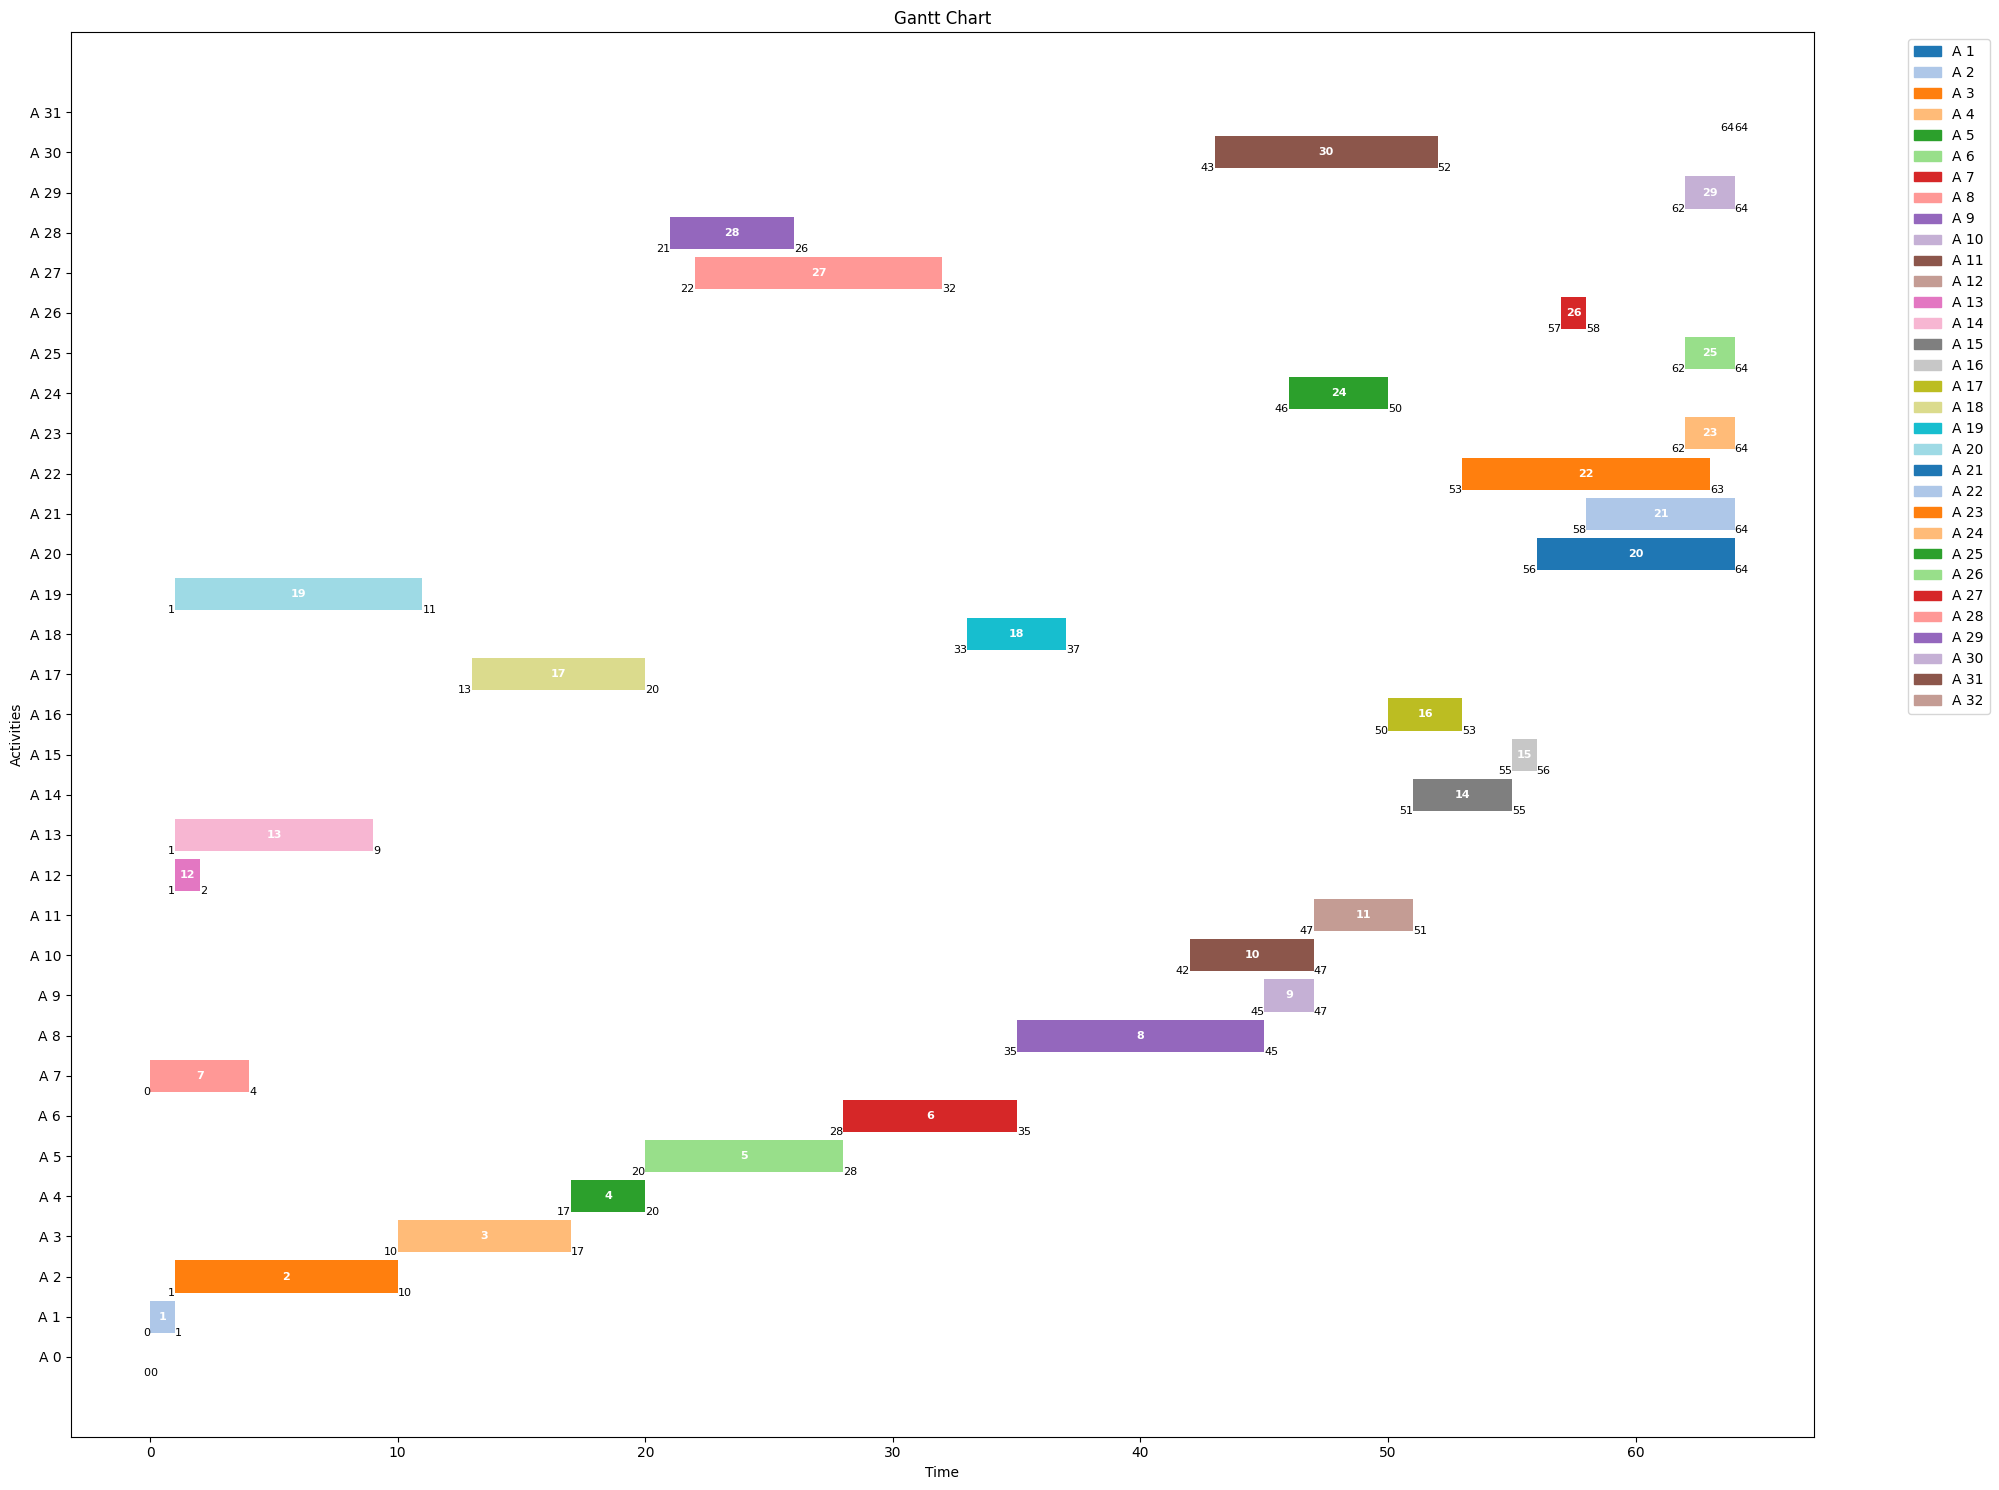

In [ ]:
generate_gantt_chart(nb_activities, duration, pat301_solution)